## Prepare imports

In [1]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf


from models.ectencoder_modelnet import BaseModel as EctEncoder
from datasets.modelnet import ModelNetDataModule, ModelNetDataModuleConfig
from layers.ect import EctLayer, EctConfig
from directions import generate_3d_directions


DEVICE = "cuda:0"

config = OmegaConf.load("./configs/config_encoder_modelnet.yaml")

## Load Models and Data

In [2]:
layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_3d_directions(config.layer.ect_size, DEVICE),
)

dm = ModelNetDataModule(
    ModelNetDataModuleConfig(name="10", samplepoints=config.data.samplepoints)
)

# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/ectencoder_3d_final.ckpt",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.encodermodel.hidden_size,
    num_pts=config.encodermodel.num_pts,
    num_dims=config.encodermodel.num_dims,
    learning_rate=config.encodermodel.learning_rate,
).to(DEVICE)


## Generate an ECT and use VAE as autoencoder to recreate the ECT

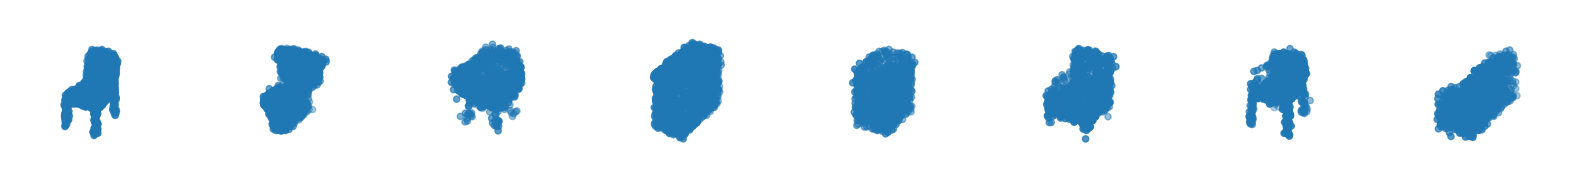

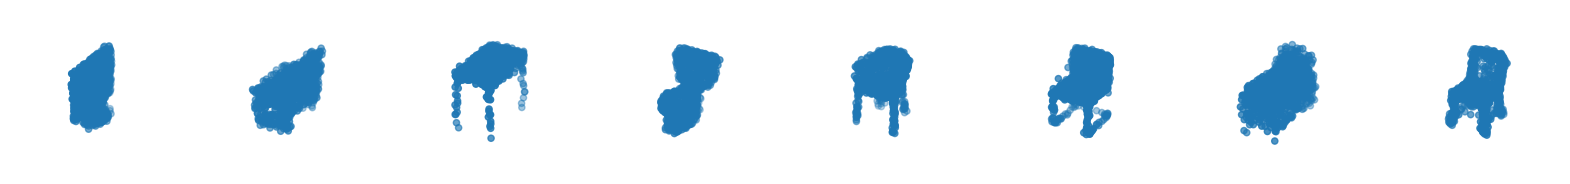

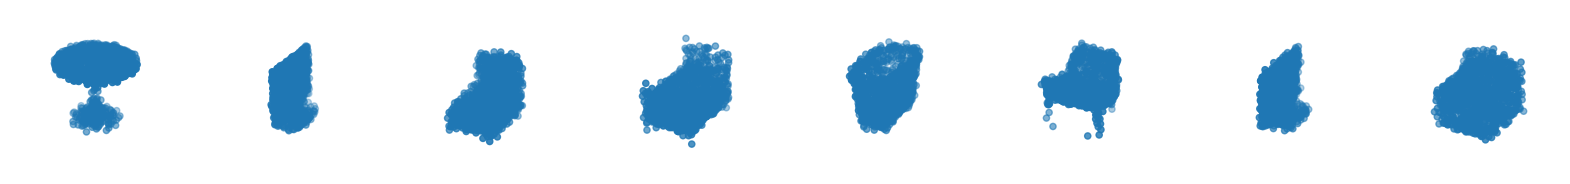

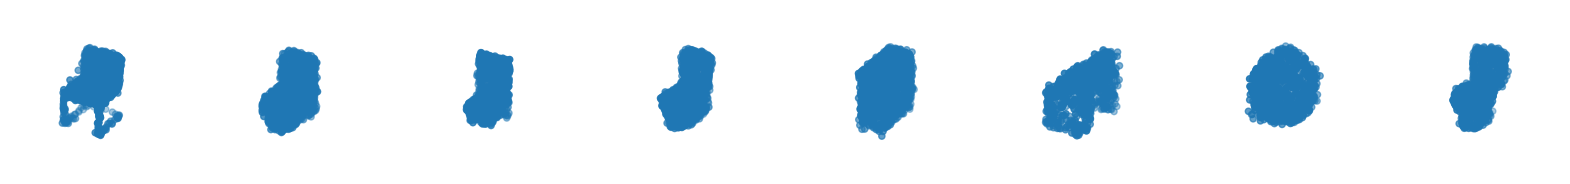

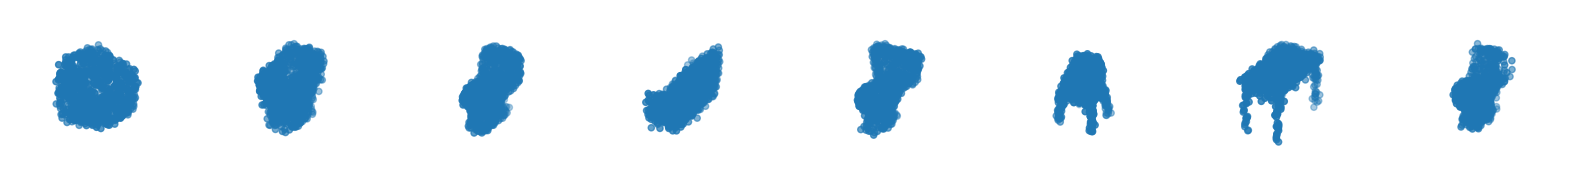

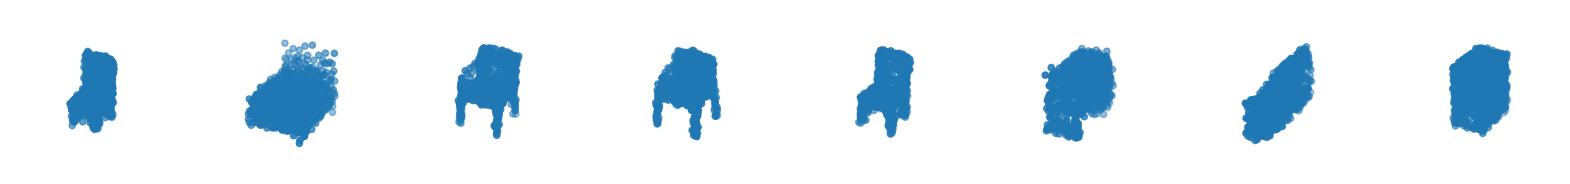

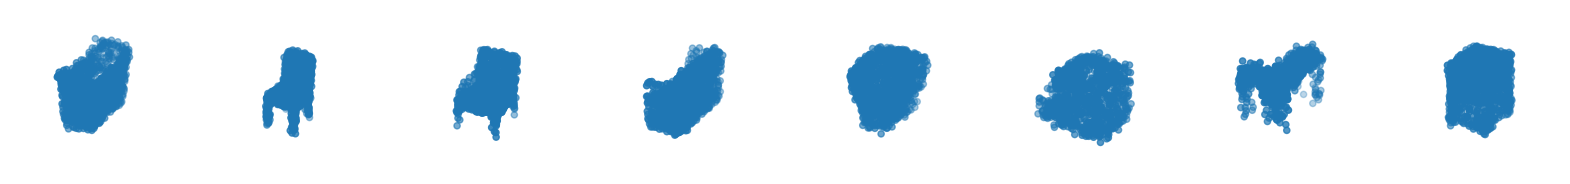

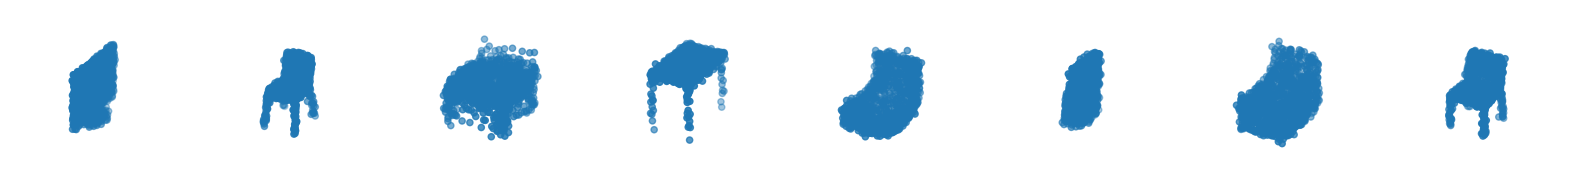

In [3]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)


# Pass reconstruction through the point cloud decoder

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect)


n_images = 8

for idx in range(0,64,8):
    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5),subplot_kw=dict(projection='3d')
    )


    for recon_pts,ax in zip(recon_batch[idx::],axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,3).cpu().detach().squeeze().numpy()


        ax.scatter(recon_pts[:,0],recon_pts[:,1],recon_pts[:,2])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.axis("off")
